# Weight decay

### Introducing some standard regulization techniques can help mitigate the problem of overfitting

#### Norms are used to minimize prediction loss on the training labels by minimizing the sum of prediction loss and the penalty term. 

$$L(\mathbf{w}, b) = \frac{1}{n}\sum_{i=1}^n \frac{1}{2}\left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right)^2.$$

#### Now we must add the L2 norm with a regulization constant

$$L(\mathbf{w}, b) + \frac{\lambda}{2} \|\mathbf{w}\|^2,$$

#### The SGD then becomes:

$$ \begin{aligned}
\mathbf{w} & \leftarrow \left(1- \eta\lambda \right) \mathbf{w} - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \mathbf{x}^{(i)} \left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right).
\end{aligned} $$

## High-Dimensional Linear Regression

In [3]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

$$y = 0.05 + \sum_{i = 1}^d 0.01 x_i + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.01^2).$$

In [4]:
#random parameters

def init_params():
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

#L2 norm:
def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2



def train(lambd):
    w, b = init_params()
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with torch.enable_grad():
                # The L2 norm penalty term has been added, and broadcasting
                # makes `l2_penalty(w)` a vector whose length is `batch_size`
                l = loss(net(X), y) + lambd * l2_penalty(w)
            l.sum().backward()
            d2l.sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('L2 norm of w:', torch.norm(w).item())

L2 norm of w: 12.866023063659668


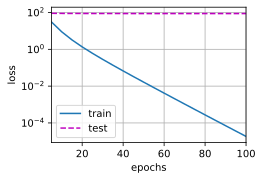

In [6]:
train(lambd=0)

In [8]:
train(lambd=3)
# as seen the value of W is reduced since you are penalizing for larger W values!

L2 norm of w: 0.37955766916275024


### Concise implementation:

In [9]:
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss()
    num_epochs, lr = 100, 0.003
    # The bias parameter has not decayed
    trainer = torch.optim.SGD([{
        "params": net[0].weight,
        'weight_decay': wd}, {
            "params": net[0].bias}], lr=lr)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with torch.enable_grad():
                trainer.zero_grad()
                l = loss(net(X), y)
            l.backward()
            trainer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('L2 norm of w:', net[0].weight.norm().item())

L2 norm of w: 14.116625785827637


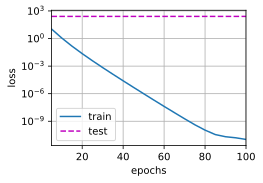

In [10]:
train_concise(0)


L2 norm of w: 0.3552945554256439


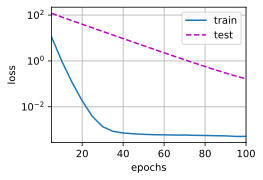

In [12]:
# The PyTorch library uses L2 norm! check documentation from: https://pytorch.org/docs/stable/optim.html
train_concise(3)